In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from scipy.integrate import ode, odeint, solve_ivp
from scipy.optimize import minimize
from scipy.stats import dirichlet

# import DOE library
from doepy import build
import itertools

np.random.seed(123)

In [2]:
### DEFINE PARAMETERS ###

# number of species in model
n_s = 5

# number of resources
n_r = 7

# p = probability that a species depends on a resource, 
# adjust p to control how often a species relies on a resource 
# increasing p (up to 1.) increases system complexity
p = .6

# product degradation rate
Kd = .005

# number of different feed rates to consider
n_u = 20

# initial and max reactor volumes (L)
v_0 = 7
v_max = 10 

# define time steps to sample data
t_batch  = 130 # hr
t_samples =  5 # how many times to collect data

# percent noise to add to data 
noise = 5.

### Compute simulation parameters ### 

# initial biomass 
s_0 = .01*np.ones(n_s)

# initial resources 
r_0 = .005*np.ones(n_r)

t_delta = t_batch // t_samples 
t_eval  = np.arange(0, t_batch+t_delta, t_delta)

# minimal amount of resource for species growth
g = np.ones(n_s)/100.

# resource degradation rates 
d = np.ones(n_r)/100.

# populate C matrix 
C = np.zeros([n_s, n_r])
for i in range(n_s):
    # generate coefficients that dictate species dependence on a resource
    theta_prime = []
    for j in range(n_r):
        if np.random.random() < p:
            theta_prime.append(np.random.random())
        else:
            theta_prime.append(0.)
    if np.sum(theta_prime) > 0.:
        theta = np.array(theta_prime)/np.sum(theta_prime)
        C[i]  = theta*(1 + .1*np.random.randn())
    else:
        # need to have dependence on at least one resource
        C[i][0] = np.abs(np.random.random()*(1 + .1*np.random.randn()))
        
# to avoid a trivial solution to resource profile, make the product producing 
# species the one that depends on the fewest number of resources. Otherwise, 
# the optimal resource profile will trivially be the one with all resources. 
Yps = np.zeros(n_s)
Yps[np.argmax(np.sum(C==0, 1))] = .5
print(Yps)

# initial amount of product
p_0 = 0.

# experimental design space for feed rate
exp_design = build.space_filling_lhs(
                {'a':[-1/2, 1/2],
                 'b':[-1/2, 1/2]},
                num_samples = n_u)
u_coefs = exp_design.values

[0.  0.5 0.  0.  0. ]


In [3]:
# define system of equations
def reactor(t, y, rf, u):
    
    # y should never be negative
    y = np.clip(y, 0, np.inf)
    
    # get species 
    v = y[0]
    s = y[1:n_s+1]
    r = y[n_s+1:-1]
    p = y[-1]
    
    # rate of change of reactor volume
    dvdt = u(t)
    
    # rate of change of species 
    dsdt = s*(C@r - g) - s*(u(t)/v)

    # rate of change of resources
    drdt = -r*(np.einsum('i,ij->j',s,C) - d) + (rf - r)*u(t)/v
    
    # rate of change of product
    dpdt = np.dot(Yps, np.clip(dsdt, 0, np.inf)) - Kd*p - p*(u(t)/v)
    
    return np.append(np.append(np.append(dvdt, dsdt), drdt), dpdt)

# define feed flow rate
def u(t, x1, x2):
    tau = t/t_batch
    x3 = -(x1 + x2)
    z = x1 + x2*(-1 + 2*tau) + x3*(1 - 6*tau + 6*tau**2)
    return 6/130 * (1 - tau)*(1 + z)

# define gLV ODE model
def run_reactor(rf, u):
    
    # solve system
    y_0 = np.append(np.append(np.append(v_0, s_0), r_0), p_0)
    soln = solve_ivp(reactor, (0, t_eval[-1]), y_0, 
                     t_eval=t_eval, args=(rf,u_in), method='LSODA')
    return soln.t, soln.y.T

In [4]:
# full factorial of resources in feed (excluding zero resources)
rfs = .1*np.array([np.array(i) for i in itertools.product([0, 1], repeat = n_r)])[1:]

In [5]:
y_vals = []
exp_names = []
D = np.zeros([len(t_eval)*u_coefs.shape[0]*rfs.shape[0], 4+n_s+n_r])
gp_df = pd.DataFrame()

k = 0
for i,rf in enumerate(rfs):
    for j,(a, b) in enumerate(u_coefs):
        # solve for factors 
        x1 = (a + b) / 2
        x2 = (a - b) / 2 

        # input function
        u_in = lambda t: u(t, x1, x2)
        
        # simulate reactor
        t, y = run_reactor(rf, u_in)    
        
        # store data
        exp_names+= [f"Exp_{k}"]*len(t_eval)
        
        # store measurement times
        D[k*len(t_eval):(k+1)*len(t_eval), 0] = t_eval

        # store species abundances 
        species_abundances = y[:, 1:1+n_s]
        species_abundances*= (1. + noise/100*np.random.randn(species_abundances.shape[0], species_abundances.shape[1]))
        D[k*len(t_eval):(k+1)*len(t_eval), 1:1+n_s] = species_abundances
        
        # store volume
        D[k*len(t_eval):(k+1)*len(t_eval), 1+n_s] = y[:, 0]
        
        # store product concentration 
        product_concentration = np.vstack(y[:, -1])
        product_concentration*= (1. + noise/100*np.random.randn(product_concentration.shape[0], product_concentration.shape[1]))
        D[k*len(t_eval):(k+1)*len(t_eval), 2+n_s:3+n_s] = product_concentration
        
        # store resource feed values
        D[k*len(t_eval):(k+1)*len(t_eval), 3+n_s:3+n_s+n_r] = rf
        
        # store feed flow input
        D[k*len(t_eval):(k+1)*len(t_eval), -1] = u_in(t_eval)
        
        # save output 
        y_vals.append(product_concentration[-1, 0]*y[-1, 0])
        
        # save [input, output] pair to gp_df 
        gp_df_sample = pd.DataFrame()
        gp_df_sample['Experiments'] = [f"Exp_{k}"]
        gp_df_sample[['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7']] = [rf]
        gp_df_sample[['x1', 'x2']] = [x1, x2]
        gp_df_sample['p'] = y_vals[-1]
        gp_df = pd.concat((gp_df, gp_df_sample))
        
        # counter
        k+=1

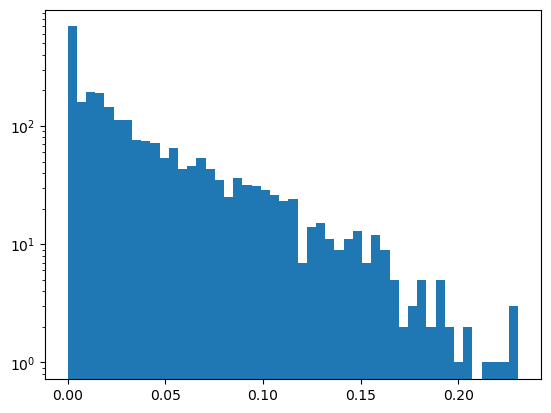

0.23082261601009366


In [6]:
bins = np.linspace(0, np.max(y_vals), 50)
plt.hist(y_vals, bins=bins)
plt.yscale("log")
plt.show()
print(np.max(y_vals))

In [7]:
# save dataframe
df = pd.DataFrame()
df['Experiments'] = exp_names
columns = ['Time'] + ['s'+str(i+1) for i in range(n_s)] + ['volume'] + ['product'] + ['rf'+str(i+1) for i in range(n_r)] + ['feed']
for j,col in enumerate(columns):
    df[col] = D[:, j]

In [8]:
df.to_csv("reactor_ubiome.csv", index=False)
gp_df.to_csv("reactor_ubiome_gp.csv", index=False)